# 1. Install & import lib

In [ ]:
!pip install imblearn scikit-plot mlflow
!pip install eli5 shap 

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

import joblib
import time, os
os.environ['TZ'] = 'Asia/Ho_Chi_Minh'
time.tzset()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from collections import Counter


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.utils import resample

# from scikitplot.metrics import plot_roc
# from scikitplot.metrics import plot_precision_recall
# from scikitplot.metrics import plot_cumulative_gain
# from scikitplot.metrics import plot_lift_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import shap
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

# 2. Data understanding & Data preparation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 all_650.csv	      Cust_1_report.html  'Mo ta bang.gsheet'
 BIDV		      Cust_2_report.html   remove_outliers.csv
 BOOK		      Cust_3_report.html   results_650.csv
 cluster_v650.csv     Cust_4_report.html   salary_before_norm.csv
'Colab Notebooks'     Cust_report.html	   salary_start.csv
'COMPUTER VISION'     FASTAI		   Torrent
 Cust_0_report.html   KAGGLE


In [ ]:

MERCHANTDATA=pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/trainning/data_thang6.csv", error_bad_lines=False)
#MERCHANT_COLUMNS=MERCHANTDATA.columns.values.tolist();
MERCHANT_COLUMNS_PROPERTIES=pd.read_excel(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/column_description.xlsx")
df_fraud_06 = pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/MERCHANT_KHONG.csv")


def get_list_columns():
    feature_cad = MERCHANT_COLUMNS_PROPERTIES.copy()
    feature_cad = feature_cad[(feature_cad["ORG_SOURCE"].isin(["CAD", "MIS_MRCH_DIM", "MIS_MR_CST_DIM","MIS_CST_FCT","MIS_MRCH_FCT","EXT"])) 
    & (feature_cad["USE_TO_MODEL"] == "Y")
    ]
    return feature_cad["COLUMN_NAME"].tolist()
    

def process_data_type(df):
    #xy ly kieu du lieu la date
    df["DAY_OPEN"]=pd.to_datetime(df["DAY_OPEN"])
    df["DAY_CLOSE"]=pd.to_datetime(df["DAY_CLOSE"])
    df["DAY_START"] = pd.to_datetime(df["DAY_START"])
    df["DAY_SUBM"] = pd.to_datetime(df["DAY_SUBM"])

    df["DAY_OPEN_YEAR"]=df["DAY_OPEN"].dt.year
    df["DAY_OPEN_MONTH"] = df["DAY_OPEN"].dt.month
    df["DAY_OPEN_DAY"] = df["DAY_OPEN"].dt.day

    df["DAY_CLOSE_YEAR"] = df["DAY_CLOSE"].dt.year
    df["DAY_CLOSE_MONTH"] = df["DAY_CLOSE"].dt.month
    df["DAY_CLOSE_DAY"] = df["DAY_CLOSE"].dt.day

    df["DAY_START_YEAR"] = df["DAY_START"].dt.year
    df["DAY_START_MONTH"] = df["DAY_START"].dt.month
    df["DAY_START_DAY"] = df["DAY_START"].dt.day

    df["DAY_SUBM_YEAR"] = df["DAY_SUBM"].dt.year
    df["DAY_SUBM_MONTH"] = df["DAY_SUBM"].dt.month
    df["DAY_SUBM_DAY"] = df["DAY_SUBM"].dt.day



    df=df.drop("DAY_CLOSE",1)
    df = df.drop("DAY_OPEN",1)
    df = df.drop("DAY_START", 1)
    df = df.drop("DAY_SUBM", 1)

    return df


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,26,28,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
index_fraud = MERCHANTDATA['MERCHANT'].isin(df_fraud_06['MERCHANT'])
df_fraud = MERCHANTDATA[index_fraud]
df_fraud['MERCH_FR'] = 1 # FRAUD
df_non_fraud = MERCHANTDATA[~index_fraud]
df_non_fraud['MERCH_FR'] = 0

df_org = df_non_fraud.append(df_fraud)

df_fraud.shape 
df_non_fraud.shape
df_org.shape
MERCHANTDATA.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(752, 384)

(56710, 384)

(57462, 384)

(57462, 384)

In [ ]:
list_col_name = get_list_columns()
df = df_org[list_col_name].copy()
df = process_data_type(df)


In [ ]:
numper_of_non_fr = 1500
df_tmp = df[df.MERCH_FR == 0]

df_sub = df_tmp.sample(numper_of_non_fr, random_state=42)
df_sub = df_sub.append(df[df.MERCH_FR == 1], ignore_index = True)
df_sub.shape

(2252, 292)

In [ ]:
df_sub.columns[df_sub.isna().any()]

Index(['NUM_OF_TERM'], dtype='object')

In [ ]:
# https://stackoverflow.com/questions/44342409/drop-column-based-on-most-frequent-value
# type(df_raw[object_cols].apply(pd.Series.value_counts, normalize=True).max())
# df_object.apply(pd.Series.value_counts, normalize=True)

In [ ]:
# check dtype dataframe 
# dtype_include=object
# num_cols = make_column_selector(dtype_include=np.number)
object_cols = df_sub.select_dtypes(include='object').columns.to_list()
num_cols = df_sub.select_dtypes(include='number').columns.to_list()
# MERCH_FR: label
rejected_cols = ['CST_AGE_SEG', 'CPLANSTYLS', 'DBA_CITY', 'DBA_CNTRY', 'FEE_CODE', 'MERCH_FR', 'MERCH_FR_TP']
num_cols = [col for col in num_cols if col not in rejected_cols]
cat_cols = [col for col in object_cols if col not in rejected_cols]
cat_label_cols = ['CST_PERF_ST', 'CST_MKT_SEG']
cat_onehot_cols = [f for f in cat_cols if f not in cat_label_cols]


features = num_cols + cat_cols

y = df_sub.MERCH_FR
x_raw = df_sub[features].copy()
x = x_raw
#x = x_raw.drop('MERCH_FR', axis=1)

# x = x[mst_features["Specs"].values]

In [ ]:
# pd.DataFrame(num_cols, columns = ['num_feature']).to_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/trainning/num_feature_model_06_20210716-101219.csv")
# pd.DataFrame(features, columns = ['feature']).to_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/trainning/feature_model_06_20210716-101219.csv")

In [ ]:
# cat_label_cols + cat_onehot_cols

['CST_PERF_ST',
 'CST_MKT_SEG',
 'CLOSE_RSN',
 'CHIP_YN',
 'COMM_FREQ',
 'ELEC_IND',
 'HO_MMSFCD',
 'LINK_TYPE',
 'MERCH_GRP',
 'REC_TYPE',
 'IS_MERGE_CIF',
 'GND',
 'CST_NATIONALITY',
 'CST_TP',
 'CST_DIMMAR_ST',
 'INR_CR_RTG',
 'IS_CST_FCT_MERG']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)
x_cv, y_cv = x_train, y_train # data for cross validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [ ]:
# 01. data sumary
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_val).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_cv).items()))

[(0, 956), (1, 479)]
[(0, 319), (1, 160)]
[(0, 225), (1, 113)]
[(0, 1275), (1, 639)]


In [ ]:
x_train.columns[x_train.isna().any()]
x_val.columns[x_val.isna().any()]
x_test.columns[x_test.isna().any()]

Index(['NUM_OF_TERM'], dtype='object')

Index(['NUM_OF_TERM'], dtype='object')

Index(['NUM_OF_TERM'], dtype='object')

In [ ]:
x_cv['NUM_OF_TERM'].isna().sum()/x_cv.shape[0]
x_train['NUM_OF_TERM'].isna().sum()/x_train.shape[0]
x_test['NUM_OF_TERM'].isna().sum()/x_test.shape[0]

0.109717868338558

0.10313588850174216

0.12130177514792899

# 3. Modeling

## 3.1. Create pipepline with resample
Thực hiện preprocessing data ở đây, rồi apply cho val set, thực hiện kiểm tra trên test set 

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
import mlflow
import mlflow.sklearn

numeric_features = num_cols
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler() # ('scaler', MinMaxScaler()    
    )])

# cat_label_cols = ['CST_PERF_ST', 'CST_MKT_SEG']
cat_ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing_val')),
    ('encoder', OrdinalEncoder() 
    )])

# cat_onehot_cols = [f for f in cat_cols if f not in cat_label_cols]
cat_onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing_val')),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore', sparse=False) 
    )])

# over sampling 
oversample = SMOTE() # ADASYN()

# modeling 
classifier = RandomForestClassifier()

preprocessor = ColumnTransformer(
    transformers=[
                  ('num', numeric_transformer, numeric_features), 
                  #('cat_label', cat_ordinal_transformer, cat_label_cols)
                  #('cat_onehot', cat_onehot_transformer, ['CLOSE_RSN','CHIP_YN']) # ['CLOSE_RSN', 'COMM_FREQ']
                 ], remainder='drop')

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('sampling', oversample),
                      ('classifier', classifier)])

cat_label_cols

['CST_PERF_ST', 'CST_MKT_SEG']

In [ ]:
preprocessor.fit(x_train)
pipeline.fit(x_train, y_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='constant',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                         

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                           

In [ ]:
'''
cat_onehot_cols
#x_train['COMM_FREQ'].describe()
x_train['COMM_FREQ'].value_counts()
x_train[cat_onehot_cols].describe()
x_train['CLOSE_RSN'].value_counts()
'''

"\ncat_onehot_cols\n#x_train['COMM_FREQ'].describe()\nx_train['COMM_FREQ'].value_counts()\nx_train[cat_onehot_cols].describe()\nx_train['CLOSE_RSN'].value_counts()\n"

In [ ]:
'''
# cat_onehot_cols
xx_train = x_train[['CLOSE_RSN', 'COMM_FREQ']].copy()
imputer = SimpleImputer(strategy='constant', fill_value='missing')
x_train_imputed = imputer.fit_transform(xx_train)
pd.DataFrame(x_train_imputed,columns=xx_train.columns).head()
# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#encoder = LabelEncoder()
x_train_encoded = encoder.fit_transform(x_train_imputed)
#x_train_encoded
pd.DataFrame(x_train_encoded, columns=encoder.get_feature_names(xx_train.columns)).head()
'''

"\n# cat_onehot_cols\nxx_train = x_train[['CLOSE_RSN', 'COMM_FREQ']].copy()\nimputer = SimpleImputer(strategy='constant', fill_value='missing')\nx_train_imputed = imputer.fit_transform(xx_train)\npd.DataFrame(x_train_imputed,columns=xx_train.columns).head()\n# Encode training data\nencoder = OneHotEncoder(handle_unknown='ignore', sparse=False)\n#encoder = LabelEncoder()\nx_train_encoded = encoder.fit_transform(x_train_imputed)\n#x_train_encoded\npd.DataFrame(x_train_encoded, columns=encoder.get_feature_names(xx_train.columns)).head()\n"

##3.2. Base_model

In [ ]:
from sklearn.metrics import classification_report
pipeline.fit(x_train, y_train)
print(classification_report(y_val, pipeline.predict(x_val)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                           

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       319
           1       0.94      0.97      0.95       160

    accuracy                           0.97       479
   macro avg       0.96      0.97      0.97       479
weighted avg       0.97      0.97      0.97       479



##3.3. Random grid to search for best hyperparameters

define parameter grid

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,               
               'classifier__bootstrap': bootstrap}

print(random_grid)

{'classifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'classifier__max_features': ['auto', 'sqrt'], 'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__bootstrap': [True, False]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
rf_random = RandomizedSearchCV(estimator = pipeline, param_distributions = random_grid, 
                               n_iter = 20, cv = cv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
# rf_random.fit(x_train, y_train)
rf_random.fit(x_cv, y_cv)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 45.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
  

In [ ]:
rf_random.best_params_
best_random = rf_random.best_estimator_
best_random.fit(x_train, y_train)

{'classifier__bootstrap': False,
 'classifier__max_depth': 20,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 400}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                           

In [ ]:
print(classification_report(y_val, best_random.predict(x_val)))
print(classification_report(y_test, best_random.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       319
           1       0.93      0.96      0.95       160

    accuracy                           0.96       479
   macro avg       0.96      0.96      0.96       479
weighted avg       0.97      0.96      0.96       479

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       225
           1       0.96      0.98      0.97       113

    accuracy                           0.98       338
   macro avg       0.97      0.98      0.98       338
weighted avg       0.98      0.98      0.98       338



# 4. Check model: cross validation

In [ ]:
# metrics
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate 
from numpy import mean

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_validate(best_random, x_cv, y_cv, scoring=scoring, cv=cv, n_jobs=-1)
# scores = cross_val_score(pipepline, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)


In [ ]:
scores

{'fit_time': array([8.35593009, 8.593539  , 8.34101248, 8.2737267 , 8.77689004,
        8.65393567, 8.00920105, 8.41577244, 8.53248096, 8.39873052,
        7.95788503, 8.21473217, 7.9704864 , 7.86780667, 5.79173088]),
 'score_time': array([0.10265732, 0.13095331, 0.13368225, 0.11193109, 0.10335445,
        0.1035974 , 0.09929228, 0.11173844, 0.11066413, 0.09981036,
        0.0993917 , 0.0965488 , 0.0963738 , 0.09623694, 0.05558062]),
 'test_accuracy': array([0.95822454, 0.98172324, 0.9843342 , 0.96344648, 0.96596859,
        0.97650131, 0.96866841, 0.97650131, 0.97127937, 0.96073298,
        0.97650131, 0.98694517, 0.95039164, 0.96344648, 0.96858639]),
 'test_f1_score': array([0.9379845 , 0.97276265, 0.97674419, 0.94656489, 0.94901961,
        0.96498054, 0.95488722, 0.96414343, 0.95719844, 0.94208494,
        0.96525097, 0.98054475, 0.92664093, 0.94615385, 0.953125  ]),
 'test_precision': array([0.93076923, 0.96899225, 0.96923077, 0.92537313, 0.9453125 ,
        0.96124031, 0.92028986

In [ ]:
print(mean(scores['test_accuracy']))
print(mean(scores['test_precision']))
print(mean(scores['test_recall']))
print(mean(scores['test_f1_score']))

0.9702167603060253
0.9471470993920658
0.9650385498687665
0.9558723920868956


In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
path = '/content/drive/MyDrive/BIDV/CARD_FRAUD/model/'
filename = path + 'finalized_model_06_'+timestr+'.sav'
joblib.dump(best_random, filename)

['/content/drive/MyDrive/BIDV/CARD_FRAUD/model/finalized_model_06_20210716-101219.sav']

# 5. Check new data

In [ ]:
fraud_mids=pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/test_real_data/FRAUD_07.csv", error_bad_lines=False)
fraud_data=pd.read_csv(r"/content/drive/MyDrive/BIDV/CARD_FRAUD/data/test_real_data/data_1207.csv", error_bad_lines=False)

In [ ]:
index_fraud_mids = fraud_data['MERCHANT'].isin(fraud_mids['MID'])
df_check = fraud_data[index_fraud_mids]
df_check['MERCH_FR'] = 1
df_check.shape

(216, 384)

In [ ]:
df_check = process_data_type(df_check[list_col_name])
df_fraud_new = df_check[features].copy()

In [ ]:
result = best_random.predict(df_fraud_new)

In [ ]:
result.sum()/len(result)

0.9351851851851852

In [ ]:
print(classification_report(df_check['MERCH_FR'], best_random.predict(df_fraud_new)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97       216

    accuracy                           0.94       216
   macro avg       0.50      0.47      0.48       216
weighted avg       1.00      0.94      0.97       216



# 6. Compare new data with training data
may be compare with fraud data

In [ ]:
df_fraud = df_sub[df_sub.MERCH_FR == 1].copy()
df_fraud.shape

(752, 292)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
%load_ext autoreload
%autoreload
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
'''
for col in num_cols:
  print('------------------------------------------------------------')
  print(col)

  plt.figure(figsize=(16,4))

  plt.subplot(141)
  sns.distplot(df_fraud[col], label="skew: " + str(np.round(df_fraud[col].skew(),2)))
  plt.title('df_fraud')
  plt.legend()

  plt.subplot(142)
  sns.distplot(df_data06[col], label="skew: " + str(np.round(df_data06[col].skew(),2)))
  plt.title('new_data_06')
  plt.legend()

  plt.subplot(143)
  sns.boxplot(df_fraud[col])
  plt.title('df_fraud')

  plt.subplot(144)
  sns.boxplot(df_data06[col])
  plt.title('new_data_06')
  plt.tight_layout()
  plt.show()

'''

'\nfor col in num_cols:\n  print(\'------------------------------------------------------------\')\n  print(col)\n\n  plt.figure(figsize=(16,4))\n\n  plt.subplot(141)\n  sns.distplot(df_fraud[col], label="skew: " + str(np.round(df_fraud[col].skew(),2)))\n  plt.title(\'df_fraud\')\n  plt.legend()\n\n  plt.subplot(142)\n  sns.distplot(df_data06[col], label="skew: " + str(np.round(df_data06[col].skew(),2)))\n  plt.title(\'new_data_06\')\n  plt.legend()\n\n  plt.subplot(143)\n  sns.boxplot(df_fraud[col])\n  plt.title(\'df_fraud\')\n\n  plt.subplot(144)\n  sns.boxplot(df_data06[col])\n  plt.title(\'new_data_06\')\n  plt.tight_layout()\n  plt.show()\n\n'

<BarContainer object of 19 artists>

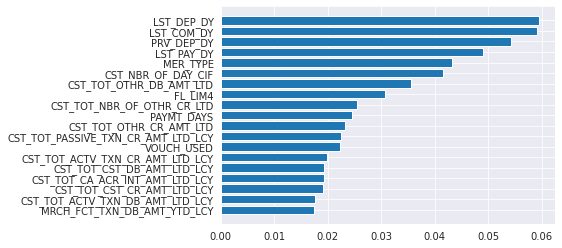

In [ ]:
sorted_idx = best_random['classifier'].feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx[-20:-1]], best_random['classifier'].feature_importances_[sorted_idx[-20:-1]])

In [ ]:
importances = best_random['classifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_random['classifier'].estimators_], axis=0)

In [ ]:
len(x_train.columns)

285

In [ ]:
forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

ValueError: ignored

In [ ]:
list_features_importances = x_train.columns[sorted_idx[-20:-1]].to_list()

In [ ]:
MERCHANT_COLUMNS_PROPERTIES.head()

In [ ]:
index_features = MERCHANT_COLUMNS_PROPERTIES['COLUMN_NAME'].isin(list_features_importances)
MERCHANT_COLUMNS_PROPERTIES[index_features].head(20)